# TM10007 Assignment template

In this part of the code a connection is made between github and this file.
All the documents from github are imported, inluding our data.
The files that are not needed for our assignment were deleted from github.

In [2]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/NFAFrijns/TM10007_G1_lipo.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [3]:
# Data loading functions. Uncomment the one you want to use
from worclipo.load_data import load_data
import pandas as pd
data = load_data()

# Printing the demensions of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

#splitting data into X and y
y  = data['label']
X = data[data.columns[1:]]
print(f'The number of samples: {len(X.index)}')
print(f'The number of samples: {len(y.index)}')
# Counting the different labels
def ratio_lipoma_liposarcoma(y):
  lipoma = 0
  liposarcoma = 0
  for i in y:
    if i == "lipoma":
      lipoma += 1
    else:
      liposarcoma += 1
  return f'{lipoma} : {liposarcoma}'
print(ratio_lipoma_liposarcoma(y))
print(type(y))
print(type(X))
print(type(data))

The number of samples: 115
The number of columns: 494
The number of samples: 115
The number of samples: 115
57 : 58
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


# Splitting the data
We will split the data in a training en test set with the following ratio 4:1 (training:test).



In [4]:
from sklearn.model_selection import train_test_split
# making the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#Dimensionality reduction - GEBLOKT DOOR IMME


## data omschrijven
Dit zijn omschrijvende factoren over de data die relevant zijn voor de feature extraction en selection

*   Data formaat = 115 punten en 490 features, dit betekent dat we hoog dimentionale data hebben, want features > datapunten. Dus je moet dimentionaliteitsreductie toepassen
*   Aantal datapunten = 115. Use a simple classifier when you don’t have many training examples
*   Is het allemaal numerieke data? Daar ga ik nu even vanuit, maar dat maakt uit voor het soort statistische test dat je gebruikt om je data te analyseren en dus ook voor je feature selection
*   Class distribution - 57/58 is een evenwichtige verdeling, wat over het algemeen gunstig is voor het trainen van je model

In [57]:
# data bekijken
# Zijn er dubbele features?

data.index.is_unique  # True als er geen dubbele features zijn

True

## Waarom dimentionaliteitsreductie?
Hier gaan we de dimentionaliteit reduceren. Er is iets dat heet 'The curse of dimentionality'.

High dimensional data is when a dataset a number of features (p) that is bigger than the number of observations (N). High dimensional data is the problem that leads to the curse of dimensionality. The equation for high dimensional data is usually written like p >> N.

Wij hebben een p van 492 en een N van 115, dus p>>n, dus hoog dimentionaal

The Hughes Phenomenon shows that as the number of features increases, the classifier’s performance increases as well until we reach the optimal number of features. Adding more features based on the same size as the training set will then degrade the classifier’s performance.

bron: https://builtin.com/data-science/curse-dimensionality

## PCA

PCA is handig om mee te beginnen omdat het relatief intuitief is en je de data handig kan visualiseren. Misschien probeer ik later nog wel wat andere dingen

**How many components to use?**
A good strategy is to choose the number of dimensions for which the cumulative explained variance exceeds a threshold, e.g., 0.95 (95%).https://www.baeldung.com/cs/pca

## Deze code
bron code: https://www.jcchouinard.com/pca-plot-visualization-python/

**Let op:** PCA does not accept missing data points, dus de code kan ik nu wel schrijven, maar het werkt alleen als Nico het voorbewerken van de data heeft gedaan

voor de code hieronder gebruik ik alleen de trainingsdata (X_train) en de labels daarvan (y_train)

**Scree Plot**
To make a scree plot, or cumulative explained variance plot, with Python and PCA, first plot an explained variance bar plot and add a secondary plot of the cumulative sum, also know as the Cumulative Explained Variance.

A scree plot is nothing more than a plot of the eigenvalues (also known as the explained variance). Essentially, it provides the same information as the Explained Variance.

In [6]:
# code for dimensionality reduction

import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
# Hyperparameters to tune:
numb_components = 20     # number of components

In [8]:
# voor nu even heel simple scaling, wachten op wat Nico doet voor echte voorbewerking
# Data Scaling
x_scaled = StandardScaler().fit_transform(X_train)

# Reduce from 4 to 3 features with PCA
pca = PCA(n_components=numb_components)

# Fit and transform data
pca_features = pca.fit_transform(x_scaled)

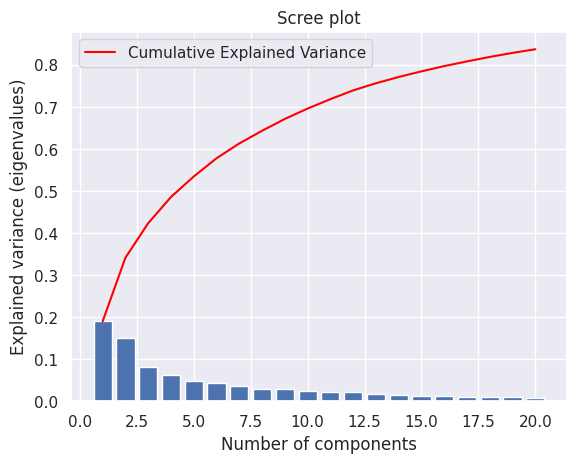

In [9]:
# Plot the Explained Variance
sns.set()

# Bar plot of explained_variance
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)

# Plot the Cumulative sum
plt.plot(range(1, len(pca.explained_variance_) + 1), np.cumsum(pca.explained_variance_ratio_), c='red',
         label='Cumulative Explained Variance')  # <-- Change explained_variance_ to explained_variance_ratio_

# Make a nice figure
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eigenvalues)')
plt.title('Scree plot')

plt.show()



# Hieronder komt een stuk over feature selection

dan kunnen we even goed vergelijken hoeveel features helemaal niets bijdragen om wat beeld te krijgen bij onze dataset. Deze methode gebruikt niet de labels, dus kijkt eigenlijk welke variabelen allemaal dezelfde waarde hebben.

"VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples."

In [17]:
# Check for zero-variance features
from sklearn.feature_selection import VarianceThreshold

# Create an instance of VarianceThreshold
selector = VarianceThreshold()

# Fit the selector to your data and transform it
relevant_features = selector.fit_transform(X_train)

print('number of zero-variance features: ', X_train.shape[1]-relevant_features.shape[1])

current shape:  (92, 493)
shape without zero-variance features:  (92, 474)
number of zero-variance features:  19


## Pearson correlation

In [70]:
# importeer modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from statsmodels.sandbox.stats.multicomp import multipletests


Veel functies werken niet als de labels strings zijn, zo kun je er numerieke labels van maken:

In [55]:
# Encode target variable
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 76  77  85  90  96  97 103 422 423 435 436 448 449 467 474 475 480 487
 488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


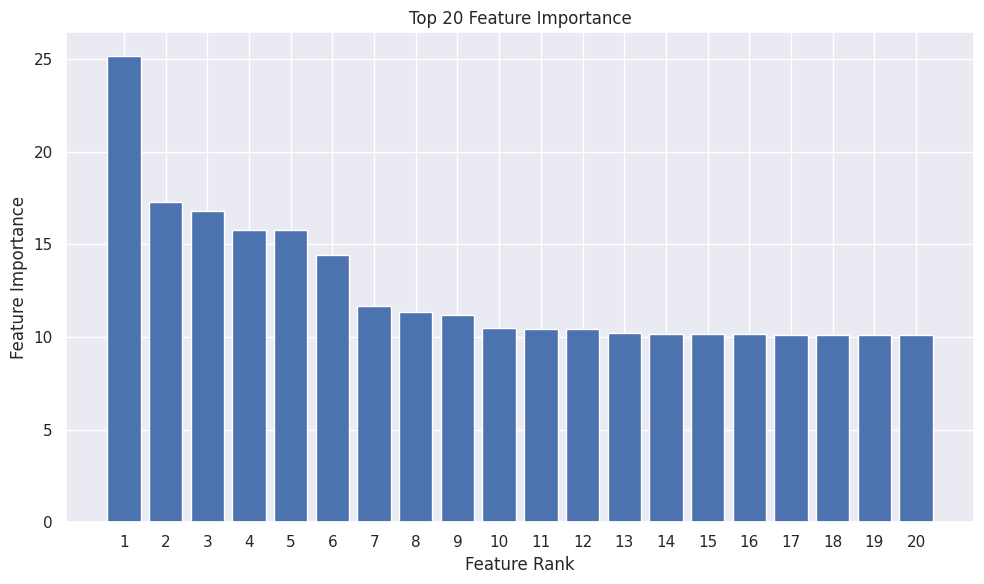

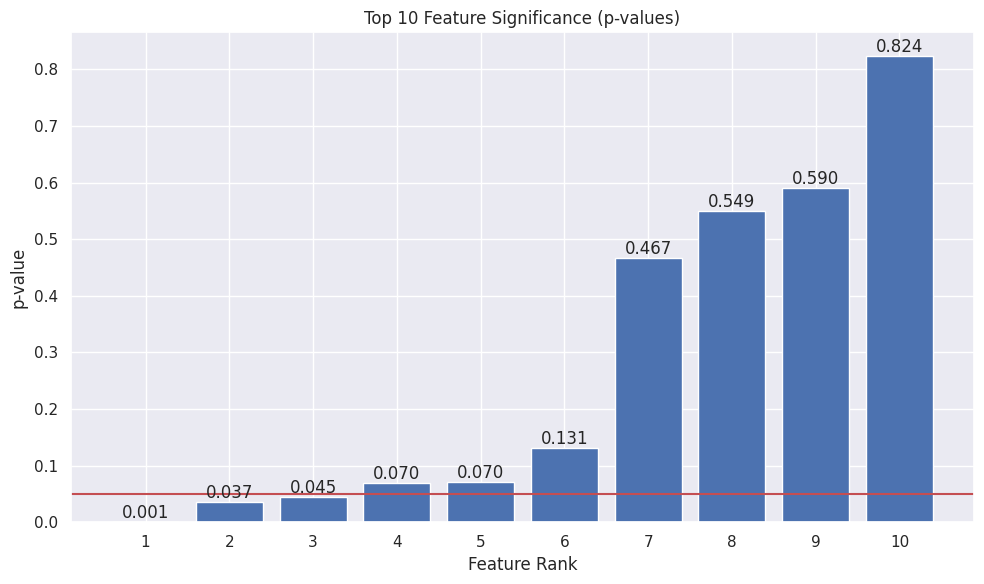

"\n\n# Sort features based on p-values and select top 10\nsorted_features = feature_stats_df.nsmallest(10, 'p-value')\n\nplt.figure(figsize=(10, 6))\nplt.bar(range(1, 11), sorted_features['p-value'])\nplt.title('Top 100 Feature Significance (p-values)')\nplt.xlabel('Feature Rank')\nplt.ylabel('p-value')\nplt.xticks(range(0, 11))\nplt.tight_layout()\nplt.axhline(y=0.05, color='r', linestyle='-')\n\n# function to add value labels\ndef addlabels(x,y):\n    for i in range(len(x)):\n        plt.text(i, y[i], y[i], ha = 'center')\n\naddlabels(range(1,11), round(sorted_features['p-value'],3))\n\nplt.show()"

In [106]:

# ------- Pearson correlation uitvoeren --------

# Compute F-statistics and p-values using f_classif
F_values, p_values = f_classif(X_train, y_train_encoded)

# Bonferroni correction on the p-values to correct for multiple testing
_, p_adjusted, _, alpha_corrected = multipletests(p_values, method='bonferroni')

# Create a DataFrame with feature names, F-values, and p-values
feature_stats_df = pd.DataFrame({'F-value': F_values, 'p-value': p_adjusted}, index=X_train.columns)


# ------- plot met feature importance --------

# Sort features based on absolute correlation values and select top 20
sorted_features = feature_stats_df.abs().nlargest(20, 'F-value')

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(1, 21), sorted_features['F-value'])
plt.title('Top 20 Feature Importance')
plt.xlabel('Feature Rank')
plt.ylabel('Feature Importance')
plt.xticks(range(1, 21))
plt.tight_layout()
plt.show()

# ------- plot met p-waardes --------

# Assuming you have already sorted your features and selected the top 10
sorted_features = feature_stats_df.nsmallest(10, 'p-value')

plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, 11), sorted_features['p-value'])
plt.title('Top 10 Feature Significance (p-values)')
plt.xlabel('Feature Rank')
plt.ylabel('p-value')
plt.xticks(range(1, 11))  # Adjusted xticks to start from 1
plt.tight_layout()
plt.axhline(y=0.05, color='r', linestyle='-')

# Function to add value labels
def addlabels(x, y):
    for i, val in enumerate(y):
        plt.text(x[i], val, f'{val:.3f}', ha='center', va='bottom')  # Adjusted text position

addlabels(range(1, 11), sorted_features['p-value'])

plt.show()


In [93]:
print(sorted_features['p-value'])

PREDICT_original_sf_volume_2.5D                0.001288
PREDICT_original_tf_Gabor_mean_F0.2_A0.79      0.036516
PREDICT_original_sf_area_max_2.5D              0.044515
PREDICT_original_sf_area_std_2.5D              0.070216
PREDICT_original_tf_Gabor_mean_F0.2_A0.0       0.070321
PREDICT_original_sf_area_avg_2.5D              0.130730
PREDICT_original_tf_Gabor_mean_F0.5_A0.0       0.466839
PREDICT_original_tf_Gabor_mean_F0.5_A0.79      0.549473
PREDICT_original_tf_Gabor_energy_F0.2_A0.0     0.590075
PREDICT_original_tf_Gabor_energy_F0.2_A1.57    0.824324
Name: p-value, dtype: float64
